In [1]:
import json
import os
from pathlib import Path
import sys
import time

import joblib
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

root = str(Path.cwd().parents[1])
sys.path.append(root)
os.chdir(root)
import src

In [ ]:
X, y, s = src.get_Xys()
y = y > 1
ys = y.astype(str) + s.astype(int).astype(str)

X = np.ascontiguousarray(X.values)
y = np.ascontiguousarray(y.values.ravel())
s = np.ascontiguousarray(s.values.ravel())
ys = np.ascontiguousarray(ys.values.ravel())

cv = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
fit_times = []

params = [
    (int(max_depth), n_bins)
    for max_depth in np.arange(1, 11)
    for n_bins in [2]
]

result_inner_folds = []
result_outer_folds = []

pbar_orthogonality_ = tqdm(np.linspace(0, 1, 11), desc='orthogonality', 
                           position=0)
for orthogonality in pbar_orthogonality_:
    pbar_orthogonality_.set_postfix({'orthogonality': orthogonality})
    
    outer_splits_ = enumerate(cv.split(X=X, y=ys))
    pbar_outer_fold_ = tqdm(outer_splits_, total=5, leave=False, 
                            desc='outer_fold', position=1)
    for outer_fold, (trainval_indices, test_indices) in pbar_outer_fold_:
        X_trainval = X[trainval_indices]
        y_trainval = y[trainval_indices]
        s_trainval = s[trainval_indices]
        ys_trainval = ys[trainval_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        s_test = s[test_indices]
    
        params_performance_ = []
        pbar_params_ = tqdm(enumerate(params), leave=False, total=len(params),
                            desc='params', position=2)
        for param_index, (max_depth, n_bins) in pbar_params_:
            assert isinstance(n_bins, int)
            assert isinstance(max_depth, int)
            params_ = {'max_depth': max_depth, 'n_bins': n_bins}
            pbar_params_.set_postfix(params_)
            param_performance_ = list()
            inner_splits_ = enumerate(cv.split(X=X_trainval, y=ys_trainval))
            pbar_inner_fold_ = tqdm(inner_splits_, total=5, leave=False, 
                                    position=3, desc='inner_fold')
            for inner_fold, (train_indices, val_indices) in pbar_inner_fold_:
                filepath_ = f'cache/notebook26/Ai-{max_depth}-{orthogonality:.2f}-{n_bins}-{outer_fold}-{inner_fold}'
                
                if os.path.isfile(filepath_ + '.json'):
                    with open(filepath_ + '.json') as file:
                        result_this_run_ = json.load(file)   
                else:
                    X_train = X_trainval[train_indices]
                    y_train = y_trainval[train_indices]
                    s_train = s_trainval[train_indices]
                    X_val = X_trainval[val_indices]
                    y_val = y_trainval[val_indices]
                    s_val = s_trainval[val_indices]

                    vt = sklearn.feature_selection.VarianceThreshold()
                    vt.fit(X_train)
                    X_train = vt.transform(X_train)
                    X_val = vt.transform(X_val) 

                    if os.path.isfile(filepath_ + '.pkl'):
                        clf = joblib.load(filepath_ + '.pkl')
                    else:
                        clf = src.FairRandomForestClassifier(
                            n_estimators=100, 
                            n_jobs=100, 
                            orthogonality=orthogonality,
                            **params_
                        )
                        start_fit = time.time()
                        clf.fit(X_train, y_train, s_train)
                        clf.fit_time = time.time() - start_fit #type: ignore
                        joblib.dump(clf, filepath_ + '.pkl')
                    y_score = clf.predict_proba(X_val)[:,1] #type: ignore
                    auc_y = sklearn.metrics.roc_auc_score(y_val, y_score)
                    auc_s = sklearn.metrics.roc_auc_score(s_val, y_score)
                    result_this_run_ = {
                        'outer_fold': outer_fold,
                        'inner_fold': inner_fold,
                        'orthogonality': orthogonality,
                        'fit_time': getattr(clf, 'fit_time', np.nan),
                        'auc_y': auc_y,
                        'auc_s': max(auc_s, 1-auc_s),
                        **params_,
                    }
                    with open(filepath_ + '.json', 'w') as file:
                        json.dump(result_this_run_, file)
                        
                result_inner_folds.append(result_this_run_)
                param_performance_.append(result_this_run_['auc_y'])

            params_performance_.append(np.mean(param_performance_))

        best_index_ = np.argmax(params_performance_)
        max_depth, n_bins = params[best_index_]

        filepath_ = f'cache/notebook26/A-{max_depth}-{orthogonality:.1f}-{outer_fold}-{n_bins}'
        
        if os.path.isfile(filepath_ + '.json'):
            with open(filepath_ + '.json') as file:
                result_this_run_ = json.load(file)
        else:
            vt = sklearn.feature_selection.VarianceThreshold()
            vt.fit(X_trainval)
            X_trainval = vt.transform(X_trainval)
            X_test = vt.transform(X_test) 

            if os.path.isfile(filepath_ + '.pkl'):
                clf = joblib.load(filepath_ + '.pkl')
            else:
                clf = src.FairRandomForestClassifier(
                    n_estimators=100, 
                    n_jobs=100, 
                    n_bins=n_bins, 
                    max_depth=max_depth, 
                    orthogonality=orthogonality
                )
                start_fit_ = time.time()
                clf.fit(X_trainval, y_trainval, s_trainval)
                clf.fit_time = time.time() - start_fit #type: ignore
                joblib.dump(clf, filepath_ + '.pkl')
                
            y_score = clf.predict_proba(X_test)[:,1] #type: ignore
            auc_y = sklearn.metrics.roc_auc_score(y_test, y_score)
            auc_s = sklearn.metrics.roc_auc_score(s_test, y_score)
            fit_time = clf.fit_time if hasattr(clf, 'fit_time') else np.nan #type: ignore
            result_this_run_ = {
                'outer_fold': int(outer_fold),
                'orthogonality': orthogonality,
                'max_depth': max_depth, 
                'n_bins': n_bins, 
                'fit_time': getattr(clf, 'fit_time', np.nan),
                'auc_y': auc_y,
                'auc_s': max(auc_s, 1-auc_s)
            }
            with open(filepath_ + '.json', 'w') as file:
                json.dump(result_this_run_, file)
        result_outer_folds.append(result_this_run_)
pd.DataFrame(result_outer_folds).to_pickle('cache/34A-outer.pkl')
pd.DataFrame(result_inner_folds).to_pickle('cache/34A-inner.pkl')

In [7]:
import pandas as pd

df = (
    pd.read_pickle('cache/34A-outer.pkl')
    .groupby('orthogonality')
    .agg({'auc_y': 'mean', 'auc_s': 'mean'})
)
df

,auc_y,auc_s
orthogonality,,
0.0,0.670240,0.660947
0.1,0.671198,0.655459
0.2,0.670453,0.649422
0.3,0.669692,0.634702
0.4,0.660500,0.611134
0.5,0.648733,0.582981
0.6,0.621947,0.547063
0.7,0.615669,0.538095
0.8,0.597449,0.528247


Text(0.5, 1.0, 'Fair Random Forest (nested gridsearch) | Scenario A\nmax_depth=[1-10] | n_estimators=100 | n_bins=2')

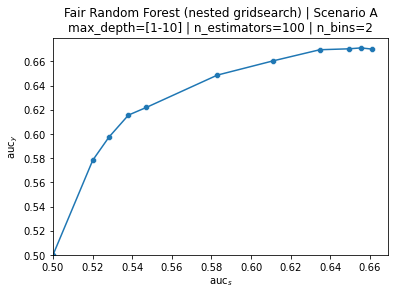

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x='auc_s', y='auc_y')
sns.scatterplot(data=df, x='auc_s', y='auc_y')
plt.xlim(.5)
plt.ylim(.5)
plt.xlabel(r'$\mathrm{auc}_s$')
plt.ylabel(r'$\mathrm{auc}_y$')
plt.title('Fair Random Forest (nested gridsearch) | Scenario A\nmax_depth=[1-10] | n_estimators=100 | n_bins=2')